# TP53 Graph Classification - Main Experiment
Predicting TP53 mutation status using single-cell RNA-seq and Graph Neural Networks.


## Setup

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import mygene
sys.path.append(os.path.abspath("../src"))
import importlib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.stats
import math
from torch_geometric.transforms import LargestConnectedComponents
import torch_geometric.utils as tg_utils
from torch_geometric.data import Data 
import networkx as nx
import torch
import seaborn as sns
import gc
from pathlib import Path
import scanpy.external as sce
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb


import load_data
import preprocessing
import network_constructor
import model_constructor

## Data import 

In [76]:
adata = load_data.load_expression_data( "../data/Expression_Matrix", verbosity=True)
df_expression=ad.AnnData.to_df(adata)
df_expression.head()


df_expression shape: (35276, 47096)
df_expression columns: Index(['ENSG00000000003', 'ENSG00000000419', 'ENSG00000000457',
       'ENSG00000000460', 'ENSG00000001036', 'ENSG00000001084',
       'ENSG00000001167', 'ENSG00000001460', 'ENSG00000001461',
       'ENSG00000001497',
       ...
       'ENSG00000271681', 'ENSG00000276605', 'ENSG00000277206',
       'ENSG00000277591', 'ENSG00000278658', 'ENSG00000279270',
       'ENSG00000280920', 'ENSG00000283420', 'ENSG00000284003',
       'ENSG00000284685'],
      dtype='object', length=47096)
df_expression head:                     ENSG00000000003  ENSG00000000419  ENSG00000000457  \
AU565_AAACCAGTTTGG              0.0              2.0              0.0   
AU565_AAACGTGCAGCG              1.0              0.0              0.0   
AU565_AAAGCCACATGC              0.0              2.0              0.0   
AU565_AAAGTCGGCTGG              0.0              0.0              0.0   
AU565_AAAGTGCCTAAA              0.0              2.0              0.0   

,ENSG00000000003,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,ENSG00000001497,...,ENSG00000271681,ENSG00000276605,ENSG00000277206,ENSG00000277591,ENSG00000278658,ENSG00000279270,ENSG00000280920,ENSG00000283420,ENSG00000284003,ENSG00000284685
AU565_AAACCAGTTTGG,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AU565_AAACGTGCAGCG,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AU565_AAAGCCACATGC,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AU565_AAAGTCGGCTGG,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AU565_AAAGTGCCTAAA,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
df_mutation = load_data.load_mutation_data("../data/Mutation/CellLineDownload_r21.csv", verbosity=True)
df_mutation = load_data.add_cleaned_column(df_mutation, column_name="Sample_Name")
df_mutation.head()

df_mutation shape: (2913, 80)
df_mutation columns: Index(['Sample_Name', 'ATCC_ID', 'Cosmic_ID', 'Short_topo', 'Morphology',
       'Tumor_origin', 'Add_info', 'Sex', 'Age', 'Country', 'Population',
       'Germline_mutation', 'Infectious_agent', 'Tobacco', 'Alcohol',
       'Exposure', 'KRAS_status', 'Other_mutations', 'TP53status', 'p53_IHC',
       'TP53_LOH', 'MUT_ID', 'hg18_Chr17_coordinates',
       'hg19_Chr17_coordinates', 'hg38_Chr17_coordinates', 'ExonIntron',
       'Codon_number', 'Description', 'Type', 'c_description', 'g_description',
       'g_description_GRCh38', 'WT_nucleotide', 'Mutant_nucleotide',
       'WT_codon', 'Mutant_codon', 'WT_AA', 'Mutant_AA', 'Effect',
       'ProtDescription', 'COSMIClink', 'TCGA_ICGC_GENIE_count', 'Hotspot',
       'AGVGDClass', 'SIFTClass', 'Polyphen2', 'REVEL', 'BayesDel',
       'StructureFunctionClass', 'TransactivationClass', 'DNEclass',
       'DNE_LOFclass', 'WAF1nWT', 'MDM2nWT', 'BAXnWT', 'AIP1nWT', 'h1433snWT',
       'GADD45nWT

,Sample_Name,ATCC_ID,Cosmic_ID,Short_topo,Morphology,Tumor_origin,Add_info,Sex,Age,Country,...,exon3,exon4,exon5,exon6,exon7,exon8,exon9,exon10,exon11,Sample_Name_cleaned
Sample_ID,,,,,,,,,,,,,,,,,,,,,
2946,SW13,CCL-105,909744.0,ADRENAL GLAND,Adrenal cortical carcinoma (C74.0),NaN,NaN,F,55.0,NaN,...,False,False,True,True,True,True,False,False,False,SW13
24833,NCI-H295,CRL-10296,908466.0,ADRENAL GLAND,Adrenal cortical carcinoma (C74.0),NaN,NaN,F,48.0,NaN,...,False,False,True,True,True,True,False,False,False,NCIH295
24979,NCI-H295R,CRL-2128,NaN,ADRENAL GLAND,Adrenal cortical carcinoma (C74.0),primary,Derived from NCI-H295 cell line,F,48.0,NaN,...,True,True,True,True,True,True,True,True,True,NCIH295R
21569,NCI-H295,CRL-10296,908466.0,ADRENAL GLAND,Adrenal cortical carcinoma (C74.0),NaN,NaN,F,48.0,NaN,...,True,True,True,True,True,True,True,True,True,NCIH295
21329,ETK-1,NaN,906861.0,BILIARY TRACT,"Adenocarcinoma, NOS",NaN,NaN,F,NaN,NaN,...,True,True,True,True,True,True,True,True,True,ETK1


In [46]:
# #PER SALVARE PER PREPROCESSING SU CLUSTER
# df_mutation.to_csv("../data/preprocessing/Mutation_status_cleaned_column.csv")
# adata.write_h5ad("../data/preprocessing/Expression_Matrix_raw.h5ad")

# EDA and Preprocessing

In [47]:
#Gene mapping
preprocessing.get_genes_symbols(adata, "gene_symbols")
print(adata.var['gene_symbols_mapped'].unique())

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
22 input query terms found dup hits:	[('ENSG00000215156', 2), ('ENSG00000227110', 2), ('ENSG00000228566', 2), ('ENSG00000280018', 2), ('E
928 input query terms found no hit:	['ENSG00000112096', 'ENSG00000130723', 'ENSG00000168078', 'ENSG00000189144', 'ENSG00000205485', 'ENS


['TSPAN6' 'DPM1' 'SCYL3' ... 'MIR4278' 'ENSG00000284003' 'ENSG00000284685']


In [48]:
#Add mutation status to adata
preprocessing.add_mutation_column(adata, df_mutation, cell_lines_column_name = "Sample_Name_cleaned", mutation_status_column="TP53status", new_obs_column="mutation_status")

Cell lines not found in df_mutation: ['HS578T' 'MCF12A' 'MX1' 'MDAMB453']
Removed 4562 cells with unknown mutation status.
Number matching lines: 30714
Percentage of matching cell: 87.07%


In [49]:
#sparsity
preprocessing.check_sparsity(adata)

Number of cells: 30714
Number of genes: 47096
Number of non-zero entries: 100804217
Sparsity: 93.03%


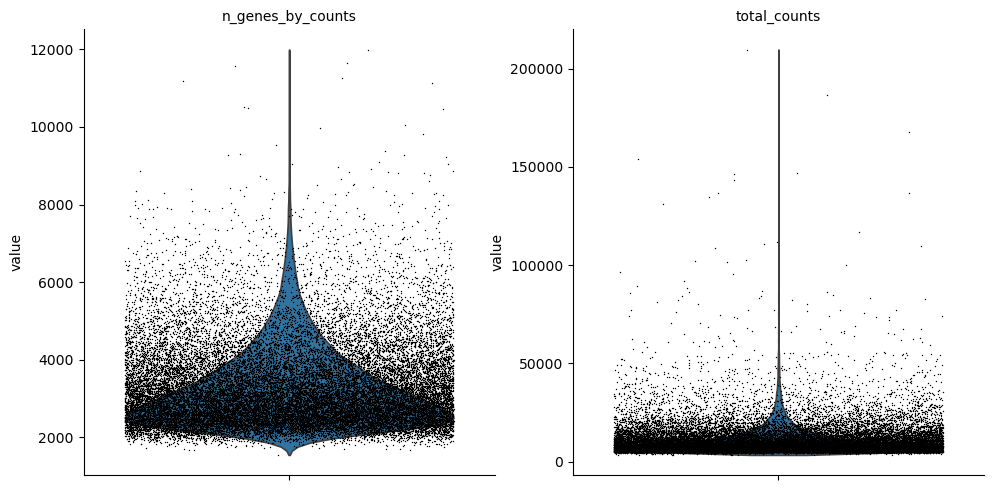

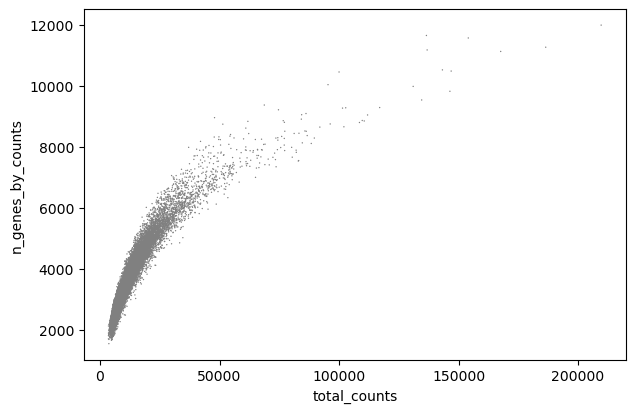

In [50]:
#Quality control
preprocessing.show_qc_plots(adata, violin_cols=['n_genes_by_counts', 'total_counts'], scatter_x='total_counts', scatter_y='n_genes_by_counts')

In [51]:
# #dublet detection     #COMPUTATIONALLY EXPENSIVE
# sc.pp.scrublet(adata)
# print(f"Number of doublets detected: {adata.obs['predicted_doublet'].sum()}")

In [52]:
#Normalization
adata.layers["raw_counts"] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata) 

In [53]:
# #ComBat to correct batch effects      #FACCIAMO SUL CLUSTER
# adata.layers["pre_combat"] = adata.X.copy()
# sc.pp.combat(adata, key="cell_line")

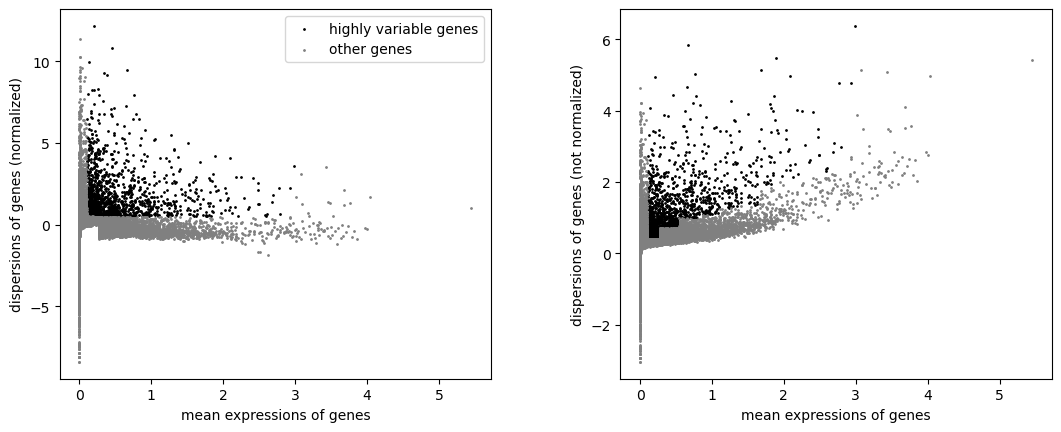

In [54]:
#Feature selection
adata.layers["pre_feature_selection"] = adata.X.copy()

# sc.pp.highly_variable_genes(
#     adata,
#     n_top_genes=2000)
sc.pp.highly_variable_genes(adata, min_mean=0.1, max_mean=3, min_disp=0.5 )   #BATCH KEY
sc.pl.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]

/opt/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:379: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


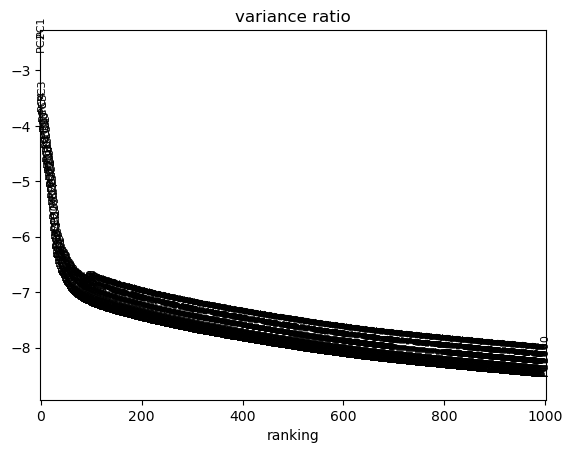

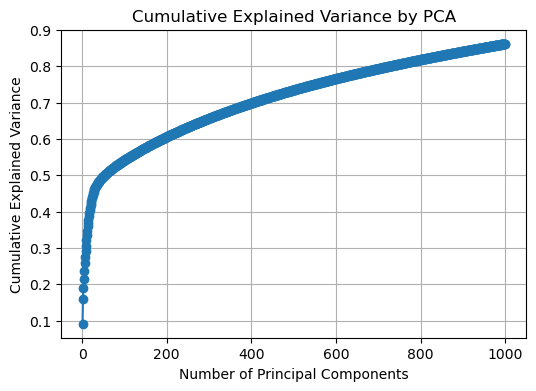

In [55]:
#pca
sc.tl.pca(adata, n_comps=1000)
sc.pl.pca_variance_ratio(adata, n_pcs=1000, log=True)


explained_variance = adata.uns['pca']['variance_ratio']
cumulative_variance = explained_variance.cumsum()


plt.figure(figsize=(6,4))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA')
plt.grid(True)
plt.show()


In [56]:
adata.obs['cell_lines'] = adata.obs_names.str.split('_').str[0]

/opt/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


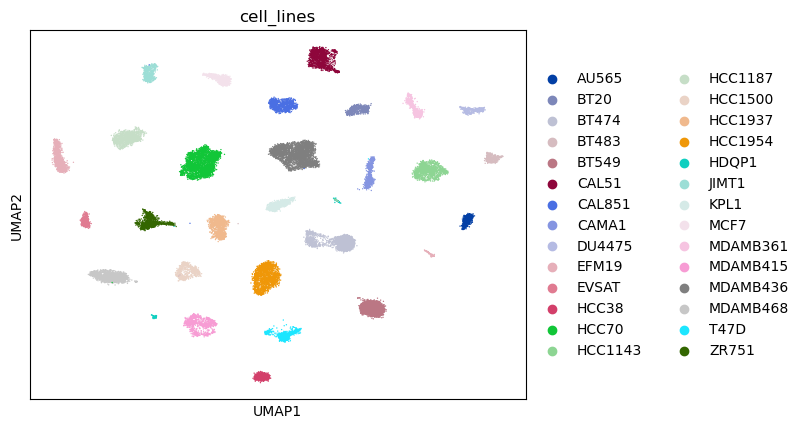

In [57]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color = "cell_lines")


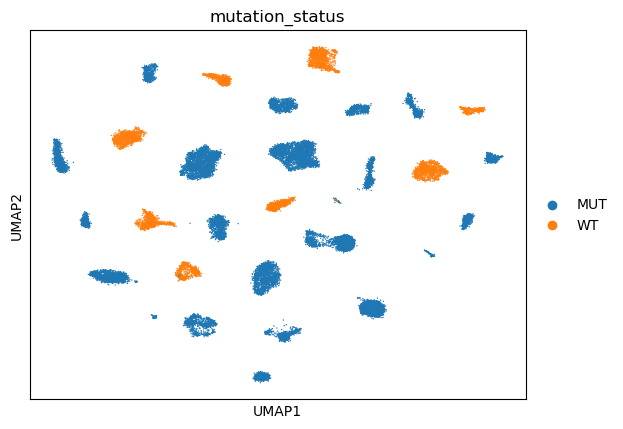

In [58]:
sc.pl.umap(adata, color = "mutation_status")

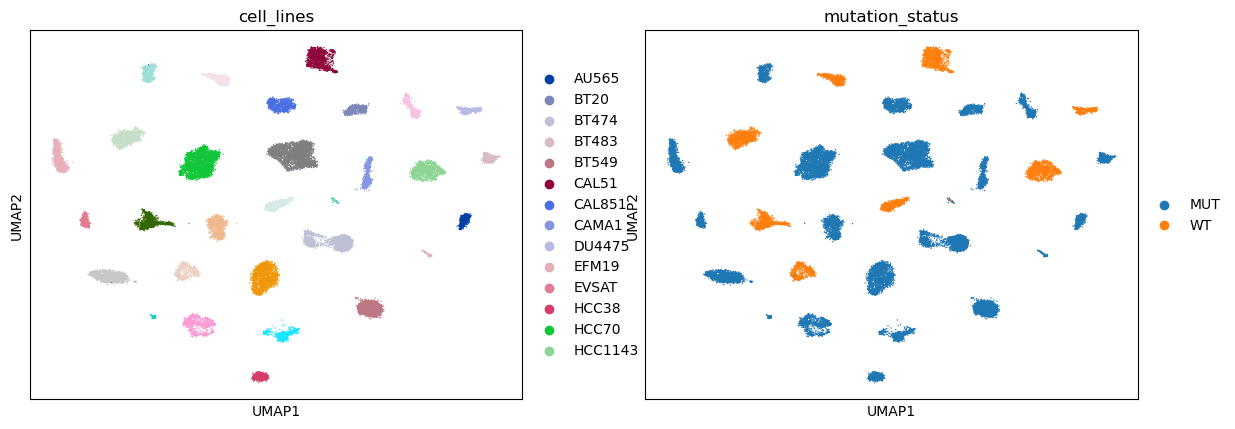

In [59]:
sc.pl.umap(adata, color = ["cell_lines","mutation_status"]) 

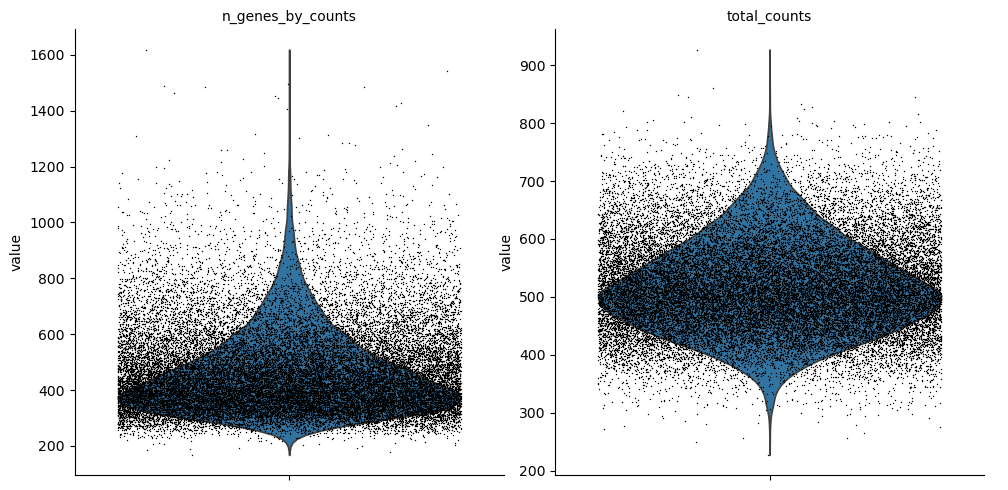

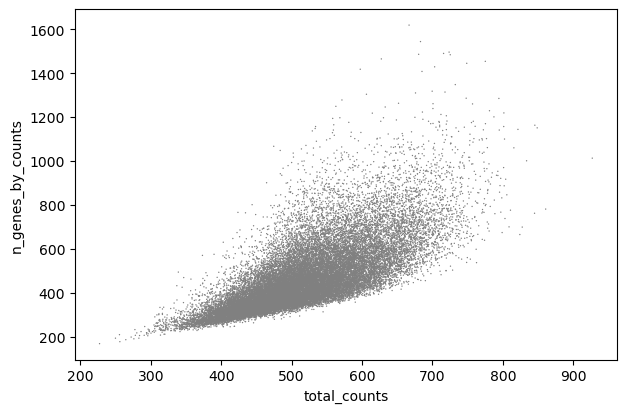

In [60]:
#Final Quality control
preprocessing.show_qc_plots(adata, violin_cols=['n_genes_by_counts', 'total_counts'], scatter_x='total_counts', scatter_y='n_genes_by_counts')

In [61]:
final_df = ad.AnnData.to_df(adata)
final_df["mutation_status"] = adata.obs["mutation_status"].values
final_df.head()

,ENSG00000001084,ENSG00000001461,ENSG00000002834,ENSG00000005884,ENSG00000006282,ENSG00000006459,ENSG00000006757,ENSG00000007944,ENSG00000008283,ENSG00000008838,...,ENSG00000104371,ENSG00000188257,ENSG00000108700,ENSG00000167656,ENSG00000167779,ENSG00000122861,ENSG00000260549,ENSG00000127951,ENSG00000170627,mutation_status
AU565_AAACCAGTTTGG,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,MUT
AU565_AAACGTGCAGCG,0.0,0.000000,0.0,0.0,0.751924,0.000000,0.751924,0.751924,0.751924,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,MUT
AU565_AAAGCCACATGC,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.924988,0.0,0.0,0.0,0.0,0.000000,MUT
AU565_AAAGTCGGCTGG,0.0,0.000000,0.0,0.0,0.000000,0.925356,0.000000,0.000000,0.925356,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.925356,MUT
AU565_AAAGTGCCTAAA,0.0,0.802482,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.546118,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,MUT


In [62]:
final_df.to_csv("final_preprocessed_data_combat.csv")

# Small test (GCN con una mut e una wt nel train e idem nel test)

In [90]:
df = pd.read_csv("final_preprocessed_data.csv", index_col=0)
df

,ENSG00000001084,ENSG00000001461,ENSG00000002834,ENSG00000005884,ENSG00000005889,ENSG00000006282,ENSG00000006459,ENSG00000006757,ENSG00000007944,ENSG00000007968,...,ENSG00000164303,ENSG00000236081,ENSG00000165643,ENSG00000188536,ENSG00000137672,ENSG00000248370,ENSG00000147256,ENSG00000164283,ENSG00000285417,mutation_status
AU565_AAACCAGTTTGG,0.0,0.000000,0.0,0.0,0.85499,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MUT
AU565_AAACGTGCAGCG,0.0,0.000000,0.0,0.0,0.00000,0.751924,0.000000,0.751924,0.751924,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MUT
AU565_AAAGCCACATGC,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MUT
AU565_AAAGTCGGCTGG,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.925356,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MUT
AU565_AAAGTGCCTAAA,0.0,0.802482,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MUT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZR751_TTTGGCCCTCGA,0.0,0.000000,0.0,0.0,0.00000,0.000000,1.002698,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WT
ZR751_TTTGGCCGGCAT,0.0,0.331385,0.0,0.0,0.00000,0.331385,0.000000,0.778723,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WT
ZR751_TTTTAGCCGTGA,0.0,0.748973,0.0,0.0,0.00000,0.748973,0.000000,1.172375,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WT
ZR751_TTTTGATATCCG,0.0,0.000000,0.0,0.0,0.00000,0.838929,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WT


In [79]:
df["cell_line"] = df.index.str.split("_").str[0]
mut_train = df[df["mutation_status"] == "MUT"]["cell_line"].unique()[0]
wt_train = df[df["mutation_status"] == "WT"]["cell_line"].unique()[0]
df_train_subset = df[(df["cell_line"] == mut_train) | (df["cell_line"] == wt_train)]
mut_test = df[df["mutation_status"] == "MUT"]["cell_line"].unique()[1]
wt_test = df[df["mutation_status"] == "WT"]["cell_line"].unique()[1]
df_test_subset = df[(df["cell_line"] == mut_test) | (df["cell_line"] == wt_test)]
df_train_subset = df_train_subset.iloc[:, :-1]
df_test_subset = df_test_subset.iloc[:,:-1]

In [80]:
df_train_subset.to_csv("df_train_subset.csv")
df_test_subset.to_csv("df_test_subset.csv")

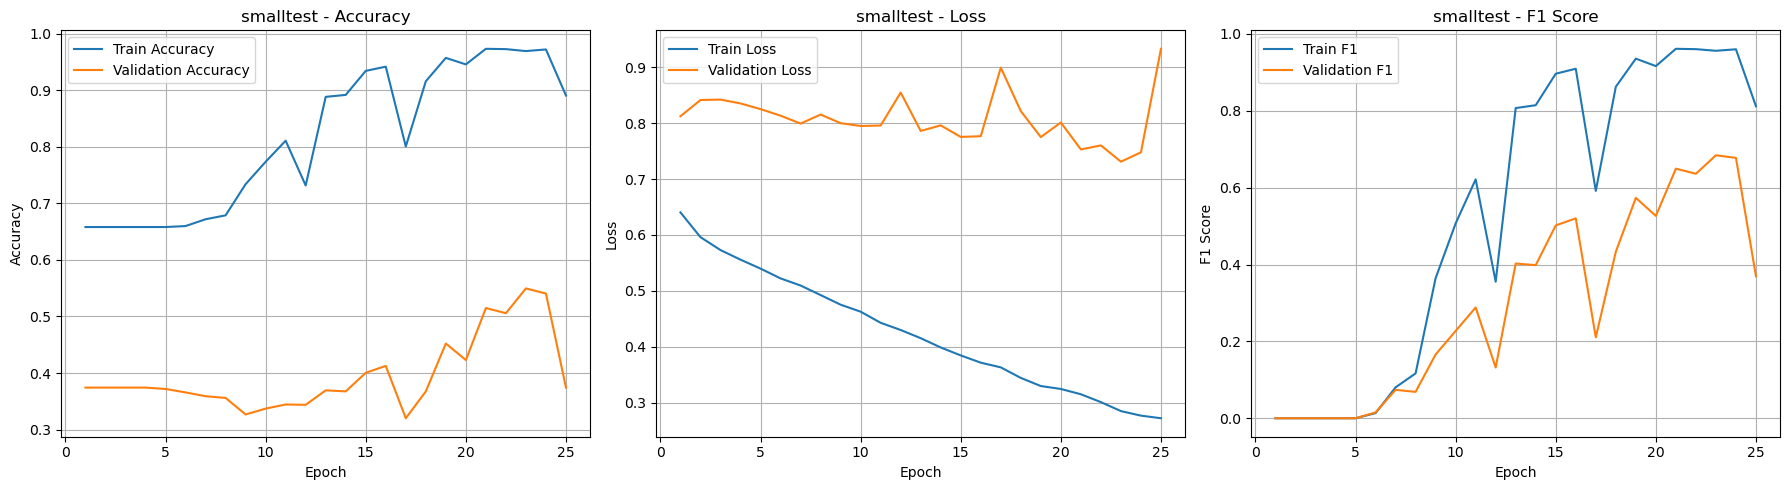

In [5]:
plot_training_curves("../Results/smalltest/training_log.csv", model_name = "smalltest")

# 3X Subsampled-Balanced XGBoost on single cell lines

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd
import xgboost as xgb

def nested_cv_holdout_xgboost(df, label_col="mutation_status", n_splits=5):
    label_mapping = {"WT": 0, "MUT": 1}
    df = df.copy()
    df[label_col] = df[label_col].map(label_mapping)

    outer_skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    outer_splits = list(outer_skf.split(df.drop(columns=[label_col]), df[label_col]))

    results = []

    for i in range(n_splits):
        print(f"Outer fold {i+1}/{n_splits} (test block)")

        test_idx = outer_splits[i][1]
        test_df = df.iloc[test_idx]
        trainval_df = df.drop(index=test_idx)

        X_test = test_df.drop(columns=[label_col])
        y_test = test_df[label_col].values

        inner_skf = StratifiedKFold(n_splits=n_splits-1, shuffle=True, random_state=42)
        inner_X = trainval_df.drop(columns=[label_col])
        inner_y = trainval_df[label_col].values

        inner_acc = []
        inner_f1 = []

        for train_idx, val_idx in inner_skf.split(inner_X, inner_y):
            X_train = inner_X.iloc[train_idx]
            y_train = inner_y[train_idx]
            X_val = inner_X.iloc[val_idx]
            y_val = inner_y[val_idx]

            model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
            model.fit(X_train, y_train)
            preds = model.predict(X_val)
            inner_acc.append(accuracy_score(y_val, preds))
            inner_f1.append(f1_score(y_val, preds))

        final_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
        final_model.fit(trainval_df.drop(columns=[label_col]), trainval_df[label_col])
        final_preds = final_model.predict(X_test)
        final_acc = accuracy_score(y_test, final_preds)
        final_f1 = f1_score(y_test, final_preds)

        results.append({
            "Outer Fold": i+1,
            "Mean Inner Accuracy": np.mean(inner_acc),
            "Mean Inner F1": np.mean(inner_f1),
            "Test Accuracy": final_acc,
            "Test F1": final_f1
        })

    return pd.DataFrame(results)


In [98]:
results = cross_val_xgboost_balanced_subsample(df, label_col="mutation_status", n_per_class=1000, n_repeats=3, n_splits=5)
print(results)

Run 1/3


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:24:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:24:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:24:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:24:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Run 2/3


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:24:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:25:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:25:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:25:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Run 3/3


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:25:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:25:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:25:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:25:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

   Run  Mean Accuracy  Mean F1 Score
0    1         0.9935       0.993494
1    2         0.9920       0.991997
2    3         0.9930       0.992972


# Simple XGB single cell balanced subsampled 


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb
import pandas as pd
import numpy as np

def xgboost_balanced_subsample(df, label_col="mutation_status", n_per_class=1000, n_repeats=3, test_size=0.2):
    label_mapping = {"WT": 0, "MUT": 1}
    df = df.copy()
    df[label_col] = df[label_col].map(label_mapping)

    all_results = []

    for run in range(n_repeats):
        print(f"Run {run + 1}/{n_repeats}")

        df_mut = df[df[label_col] == 1].sample(n=n_per_class, random_state=run)
        df_wt = df[df[label_col] == 0].sample(n=n_per_class, random_state=run)
        df_balanced = pd.concat([df_mut, df_wt]).sample(frac=1, random_state=run).reset_index(drop=True)

        X = df_balanced.drop(columns=[label_col])
        y = df_balanced[label_col].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=run)

        model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=run)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        all_results.append({
            "Run": run + 1,
            "Accuracy": acc,
            "F1 Score": f1
        })

    return pd.DataFrame(all_results)


In [95]:
results = xgboost_balanced_subsample(df)
print(results)

Run 1/3


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:53:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Run 2/3


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:54:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Run 3/3


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:54:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


   Run  Accuracy  F1 Score
0    1    0.9925  0.992443
1    2    0.9975  0.997494
2    3    0.9975  0.997494


# Network Construction

In [ ]:
df = pd.read_csv("final_preprocessed_data.csv", index_col=0)
df.shape

(30714, 2071)

In [64]:
#Split in train and test set
train_df, test_df = network_constructor.train_test_split(df, test_size=0.2, random_state=42)
print(f"shape del train test: {train_df.shape} \nshape del test set: {test_df.shape}")

shape del train test: (24571, 2071) 
shape del test set: (6143, 2071)


Percentage of non-zero values in the correlation matrix: 0.025490909939555183


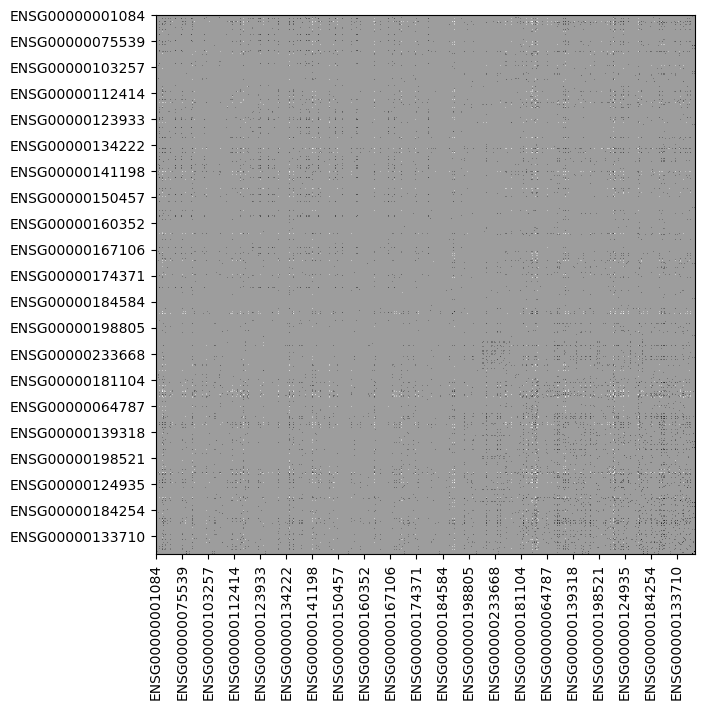

In [65]:
#Construction of the correlation matrix
mat=network_constructor.build_correlation_matrix(train_df.iloc[:,:-1], corr_threshold=0.2, p_value_threshold=0.05) 
network_constructor.check_percentage_of_zeros(mat)
network_constructor.plot_the_correlation_matrix(train_df, mat)

In [66]:
# #COSTRUZIONE DEI GRAFI, LA FACCIAMO SUL CLUSTER QUA NE FACCIAMO SOLO 50 PER TESTARE

# train_df_pyg = network_constructor.create_PyG_graph_from_df(train_df[:50], mat, label_column="mutation_status")
# test_df_pyg = network_constructor.create_PyG_graph_from_df(test_df[:20], mat, label_column="mutation_status")

# #check
# print(f"First element of train_df_pyg: {train_df_pyg[0]}")
# print(f"First element of test_df_pyg: {test_df_pyg[0]}")
# assert network_constructor.check_graph_structure(train_df_pyg), "The graphs in the train set do not have the same structure."
# assert network_constructor.check_graph_structure(test_df_pyg), "The graphs in the test set do not have the same structure."

In [67]:
#LOAD THE GRAPHS OBTAINED ON THE CLUSTER
first_train_batch = torch.load("../data/graphs_baseline/train/batch_000.pt", weights_only=False)
first_test_batch = torch.load("../data/graphs_baseline/test/batch_000.pt", weights_only=False)

#check
print(f"First element of train_df_pyg: {first_train_batch[0]}")
print(f"First element of test_df_pyg: {first_test_batch[0]}")
assert network_constructor.check_graph_structure(first_train_batch), "The graphs in the train set do not have the same structure."
assert network_constructor.check_graph_structure(first_test_batch), "The graphs in the test set do not have the same structure."

FileNotFoundError: [Errno 2] No such file or directory: '../data/graphs_baseline/train/batch_000.pt'

Number of nodes: 3808
Number of edges: 3323612
NUmber of features per node: 1
Has isolated nodes: True
Has self-loops: False
Is undirected: True


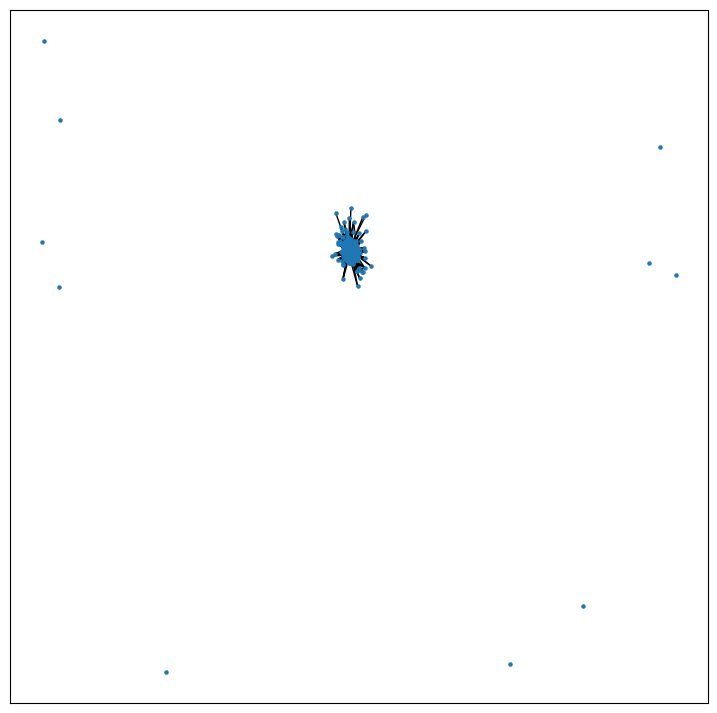

In [ ]:
network_constructor.get_info_and_plot_graph(first_train_batch)

# Model comparison

In [6]:
def plot_training_curves(csv_path, model_name="Model"):
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    df = pd.read_csv(csv_path)
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    sns.lineplot(data=df, x="Epoch", y="Train Accuracy", label="Train Accuracy")
    sns.lineplot(data=df, x="Epoch", y="Test Accuracy", label="Validation Accuracy")
    plt.title(f"{model_name} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)

    plt.subplot(1, 3, 2)
    sns.lineplot(data=df, x="Epoch", y="Loss", label="Train Loss")
    if "Test Loss" in df.columns:
        sns.lineplot(data=df, x="Epoch", y="Test Loss", label="Validation Loss")
    plt.title(f"{model_name} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)

    plt.subplot(1, 3, 3)
    f1_plotted = False
    if "Train F1" in df.columns:
        sns.lineplot(data=df, x="Epoch", y="Train F1", label="Train F1")
        f1_plotted = True
    if "Test F1" in df.columns:
        sns.lineplot(data=df, x="Epoch", y="Test F1", label="Validation F1")
        f1_plotted = True
    if f1_plotted:
        plt.title(f"{model_name} - F1 Score")
        plt.xlabel("Epoch")
        plt.ylabel("F1 Score")
        plt.grid(True)
    else:
        plt.axis('off')

    plt.tight_layout()
    plt.show()


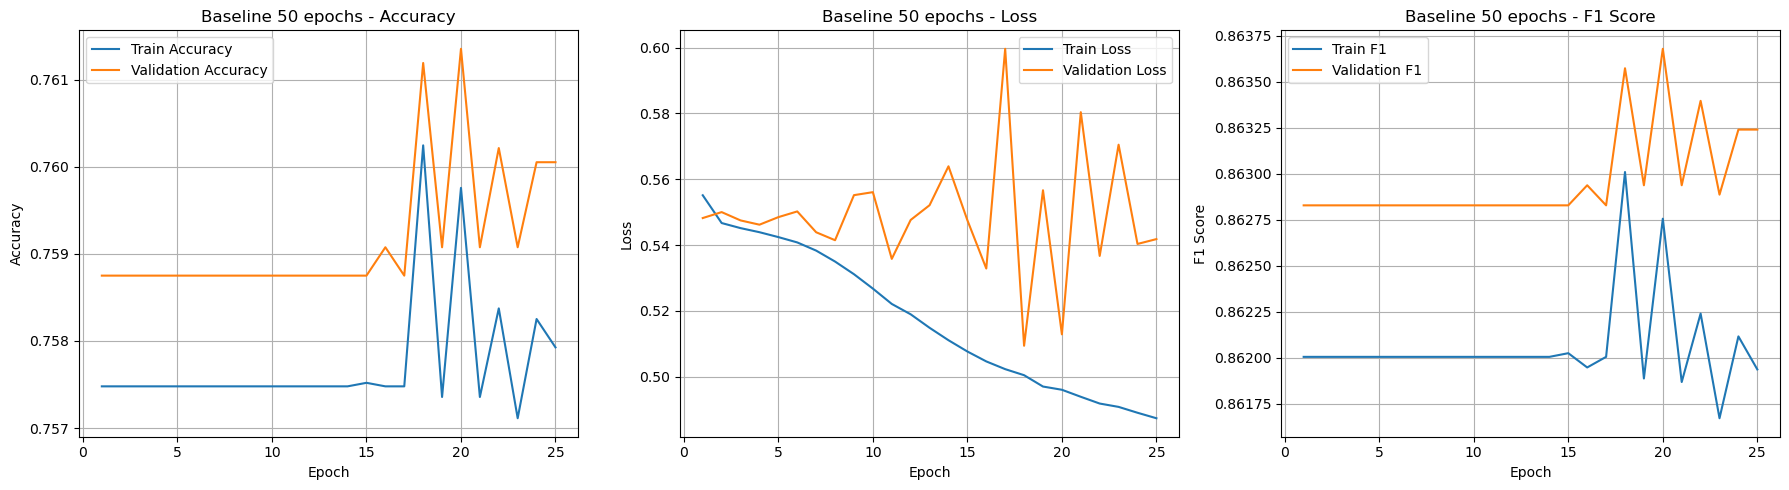

In [ ]:
plot_training_curves("../Results/Baseline/training_log.csv", model_name= "Baseline")

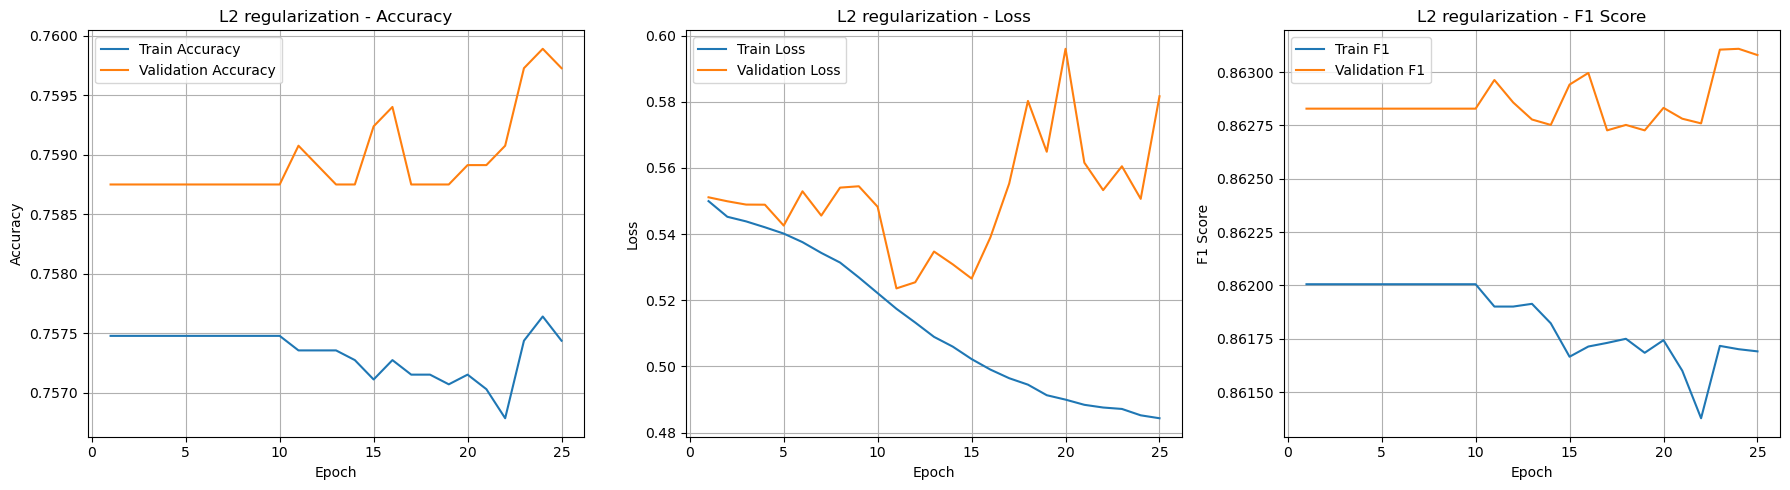

In [9]:
plot_training_curves("../Results/L2reg/training_log.csv", model_name = "L2 regularization")

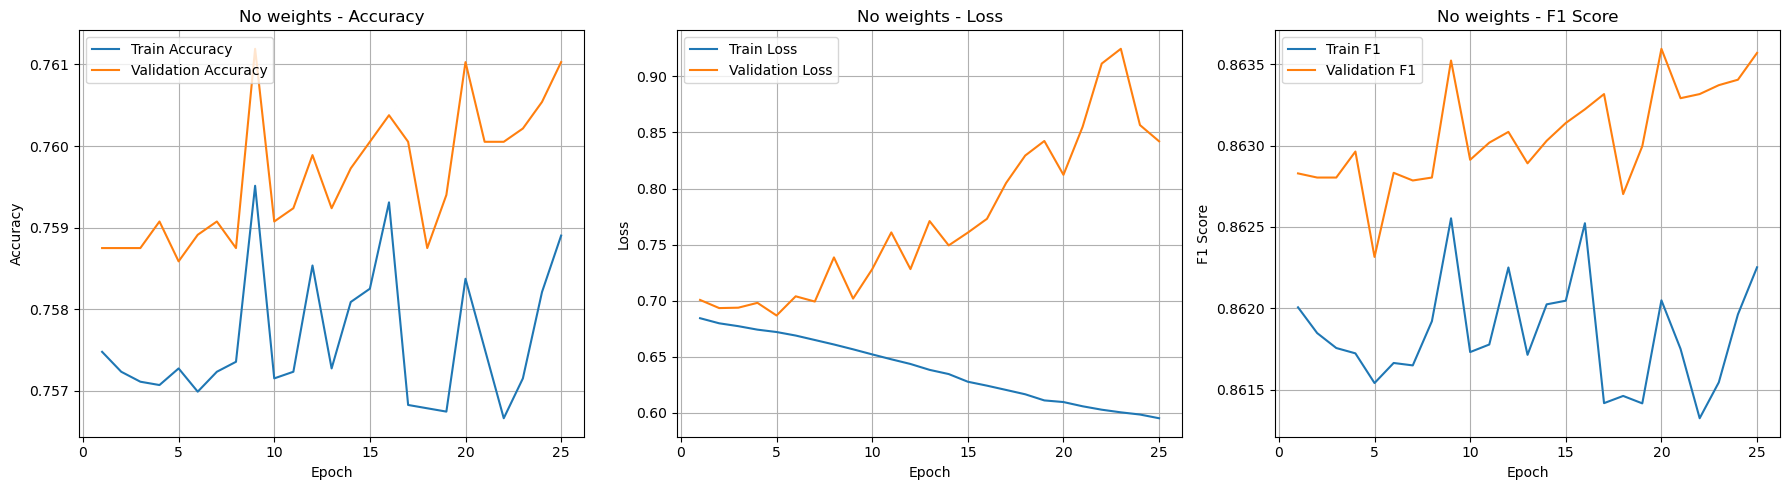

In [ ]:
plot_training_curves("../Results/weight/training_log.csv", model_name = "weights")

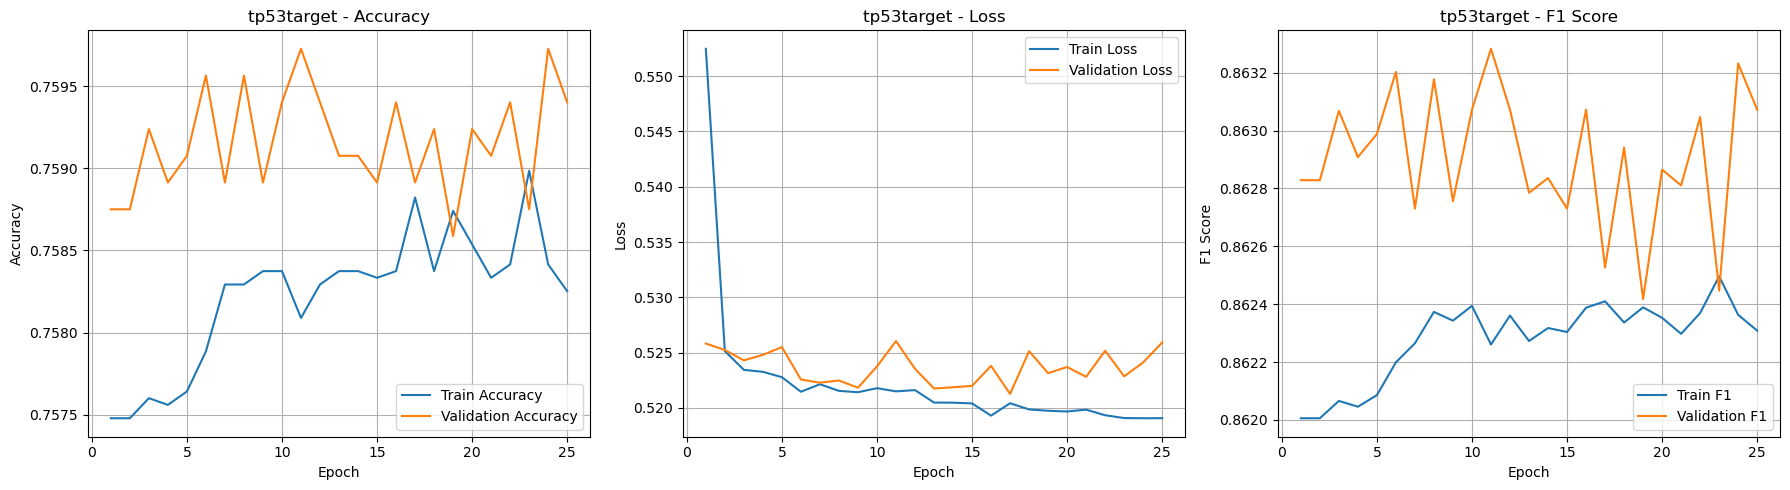

In [12]:
plot_training_curves("../Results/target/training_log.csv", model_name = "tp53target")

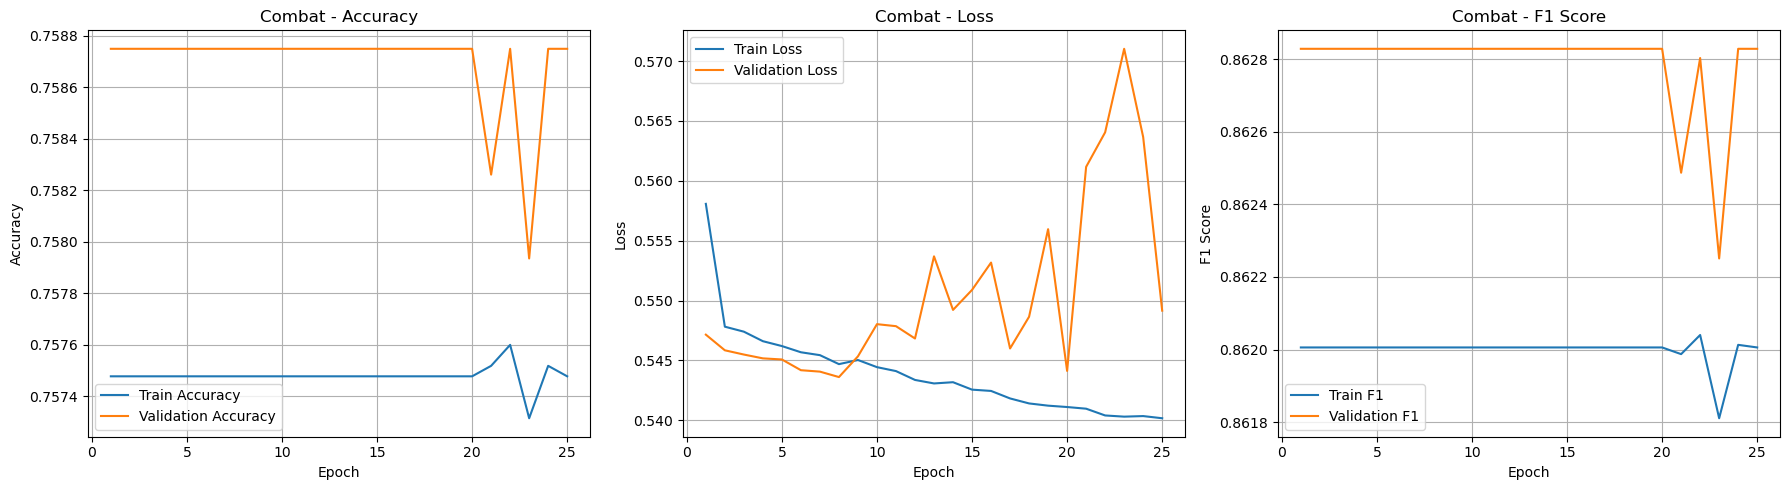

In [13]:
plot_training_curves("../Results/Combat/training_log.csv", model_name = "Combat")

/opt/anaconda3/lib/python3.11/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 2070 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


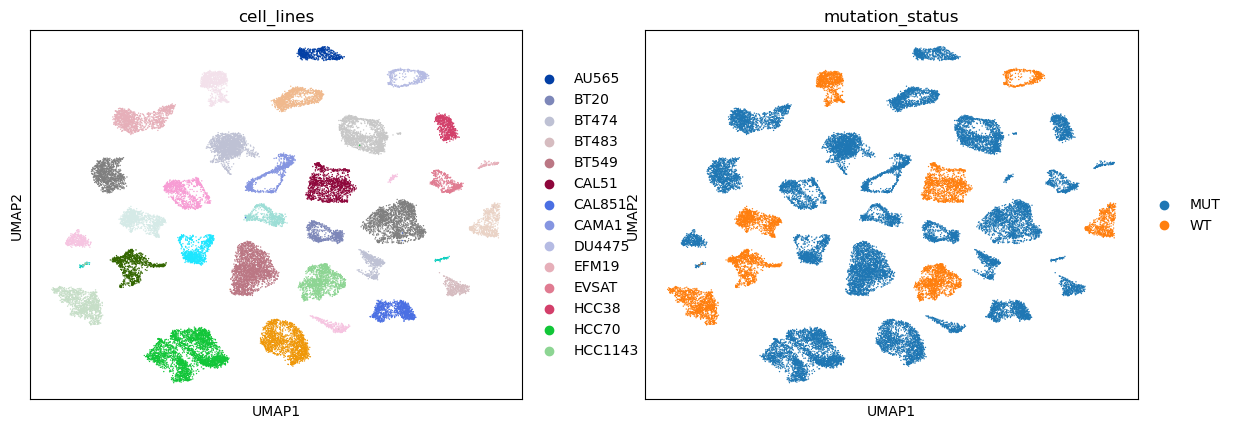

In [14]:
df_temp=pd.read_csv("../notebooks/final_preprocessed_data_combat.csv",index_col=0)
feature_cols = df_temp.columns[:-1]
mut_status = df_temp.columns[-1]
adata_batch = ad.AnnData(X=df_temp[feature_cols].values)
adata_batch.obs_names = df_temp.index
adata_batch.var_names = feature_cols
adata_batch.obs[mut_status] = df_temp[mut_status].values
adata_batch.obs["cell_lines"] = adata_batch.obs_names.str.split("_").str[0]
sc.pp.neighbors(adata_batch)
sc.tl.umap(adata_batch)
sc.pl.umap(adata_batch, color = ["cell_lines","mutation_status"])


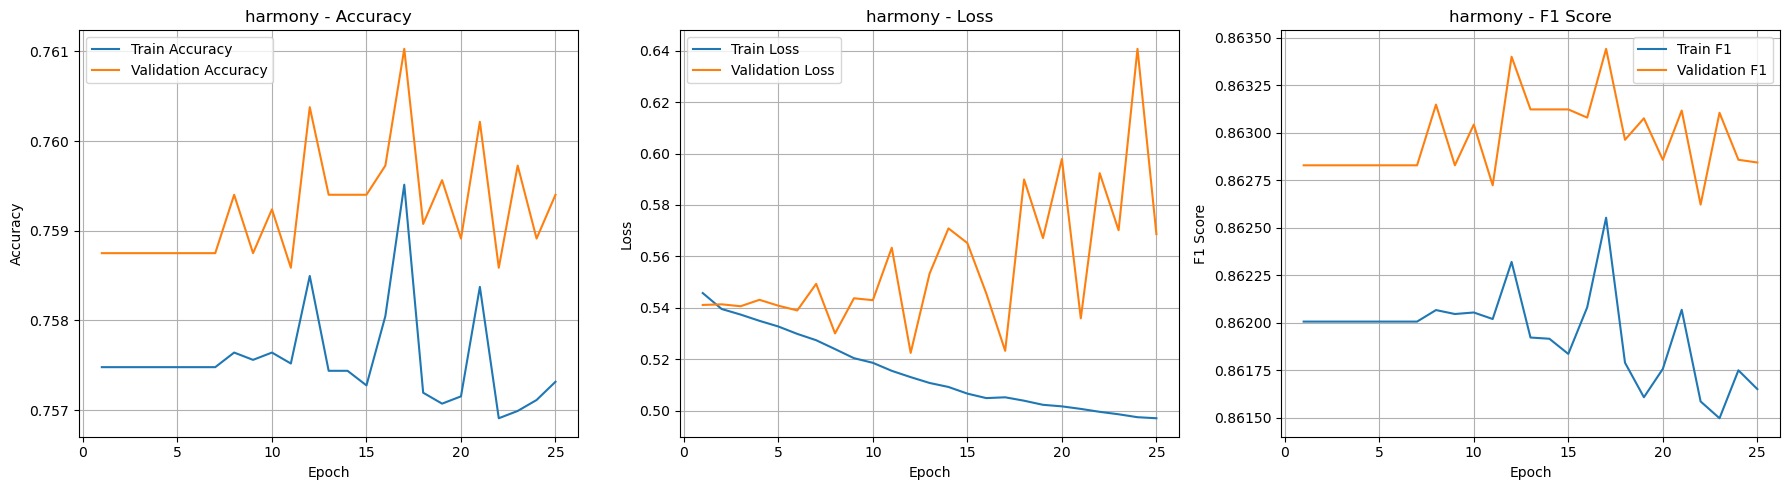

In [15]:
plot_training_curves("../Results/harmony/training_log.csv", model_name = "harmony")

/opt/anaconda3/lib/python3.11/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 2070 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


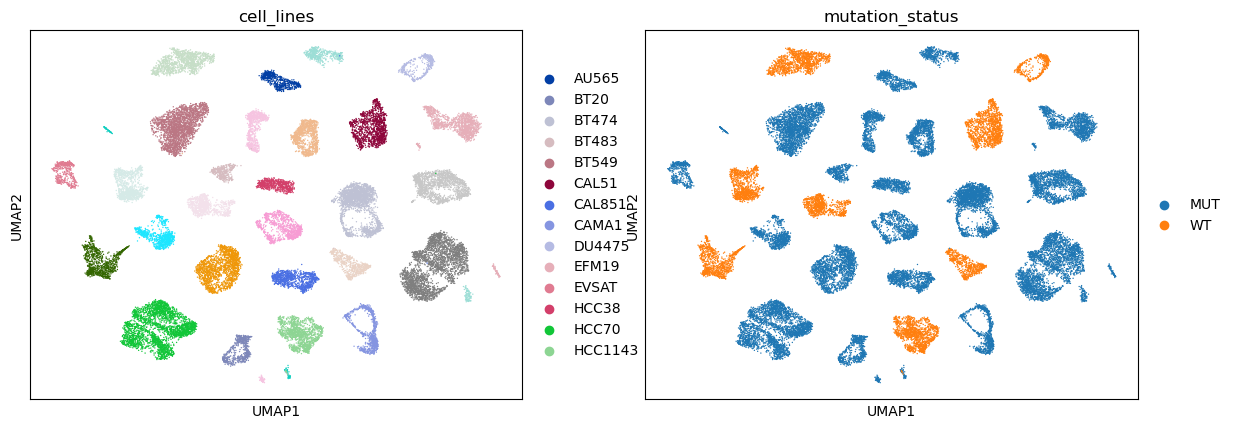

In [16]:
df_temp=pd.read_csv("../notebooks/final_preprocessed_data_harmony.csv",index_col=0)
feature_cols = df_temp.columns[:-1]
mut_status = df_temp.columns[-1]
adata_batch = ad.AnnData(X=df_temp[feature_cols].values)
adata_batch.obs_names = df_temp.index
adata_batch.var_names = feature_cols
adata_batch.obs[mut_status] = df_temp[mut_status].values
adata_batch.obs["cell_lines"] = adata_batch.obs_names.str.split("_").str[0]
sc.pp.neighbors(adata_batch)
sc.tl.umap(adata_batch)
sc.pl.umap(adata_batch, color = ["cell_lines","mutation_status"])

# Check on target genes

## define functions

In [77]:
def plot_frequency_of_correlation_values(matrices, bins=50, alpha=0.5):
    """
    Plot the frequency of correlation values.
    """
    plt.figure(figsize=(10, 6))
    bin_edges = np.linspace(-1, 1, bins + 1)

    for label,mat in matrices.items():
        mat_copia = mat.copy()
        np.fill_diagonal(mat_copia, np.nan) 
        values = mat_copia.flatten()
        plt.hist(values, bins=bin_edges, alpha=alpha, label=label, edgecolor='black') #density=True
        mean_val = np.mean(values)
        plt.axvline(mean_val, linestyle='--', linewidth=2)
    plt.yscale('log')
    plt.legend()
    plt.title('Hist of Correlation Values')
    plt.xlabel('Correlation Value')
    plt.ylabel('Absolute frequence')
    plt.grid(True)
    plt.show()

In [78]:
def import_and_create_matrices_for_plotting(path,mat_name,col_name="Ensembl ID",verbosity=False):
    "Expect to have a column named 'Ensembl ID' in the excel file, can specify the name of the columns otherwise with col_name"
    tab = pd.read_excel(path)
    tab_ensembl_ids = [gene for gene in tab[col_name] if gene in df.columns]
    df_tab = df[tab_ensembl_ids].copy()
    mat_tab=network_constructor.build_correlation_matrix(df_tab, corr_threshold=0., p_value_threshold= 1)
    if verbosity==True:
        df_tab.head()
        network_constructor.check_percentage_of_zeros(mat_tab)
    return mat_tab

In [79]:
def plot_correlation_comparison(df_expression,path_list):
    if not isinstance(path_list, list):
        path_list = [path_list]

    
    mat=network_constructor.build_correlation_matrix(df_expression, corr_threshold=0., p_value_threshold= 1)
    
    plot_frequency_of_correlation_values({"Original":mat}, bins=50, alpha=0.5)
    plt.close("all")
    del mat
    gc.collect()
    
    for path in path_list:
        label= path.split("/")[-1].split(".")[0]
        mat = import_and_create_matrices_for_plotting(path, mat_name=label, col_name="Ensembl ID", verbosity=False)
        plot_frequency_of_correlation_values({label:mat}, bins=50, alpha=0.5)
        del mat
        gc.collect()

In [ ]:
def plot_mean_expression_by_gene(df_mut, df_wt):
    df_mut_genes = df_mut.drop(columns=["mutation_type"]).copy()
    df_wt_genes = df_wt.drop(columns=["mutation_type"]).copy()
    means_mut = df_mut_genes.mean(axis=0)
    means_wt = df_wt_genes.mean(axis=0)
    total_means = means_mut + means_wt
    sorted_genes = total_means.sort_values(ascending=False).index
    means_mut = means_mut[sorted_genes]
    means_wt = means_wt[sorted_genes]

    x = range(len(sorted_genes))
    plt.figure(figsize=(12, 6))
    plt.bar(x, means_wt, label="WT", alpha=0.6)
    plt.bar(x, means_mut, bottom=means_wt, label="MUT", alpha=0.6)
    plt.xticks(ticks=x, labels=sorted_genes, rotation=90)
    plt.ylabel("Mean Expression per Gene")
    plt.title("Mean Gene Expression (normalized by group size)")
    plt.legend()
    plt.tight_layout()
    plt.grid(True, axis='y')
    plt.show()


## single cell comparison

In [ ]:
#import target genes and create target genes df
tab1 = pd.read_excel('../data/Target_genes/41388_2017_BFonc2016502_MOESM5_ESM_tab1.xlsx')
tab1_ensembl_ids = [gene for gene in tab1["Ensembl ID"] if gene in df.columns]
df_tab1 = df[tab1_ensembl_ids].copy()
mat_tab1=network_constructor.build_correlation_matrix(df_tab1, corr_threshold=0., p_value_threshold= 1, p_val="no") #PER ORA NO THRESHOLD
network_constructor.check_percentage_of_zeros(mat_tab1)
mat_original=network_constructor.build_correlation_matrix(train_df.iloc[:,:-1], corr_threshold=0., p_value_threshold= 1,p_val="no") #PER ORA NO THRESHOLD
network_constructor.check_percentage_of_zeros(mat_original)


Percentage of non-zero values in the correlation matrix: 0.9893617021276596
Percentage of non-zero values in the correlation matrix: 0.9995169082125603


TAB1 è il csv con 350 target tp53 genes

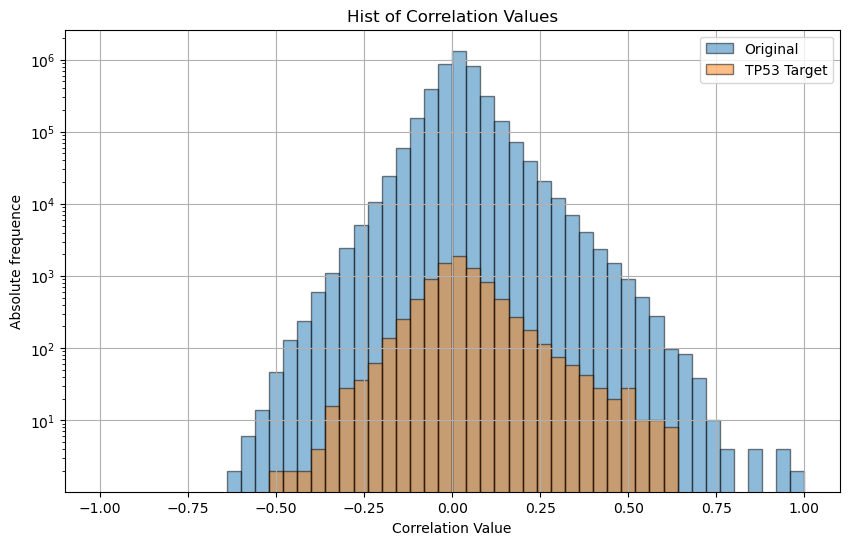

In [82]:
plot_frequency_of_correlation_values({"Original":mat_original,"TP53 Target":mat_tab1})

In [83]:
from scipy.stats import ks_2samp
stat, pval = ks_2samp(mat.flatten(), mat_tab1.flatten())
print(f"KS: {stat}, p-value: {pval}")

KS: 0.5811017668126826, p-value: 0.0


## bulk data comparison

In [ ]:
#import bulk data
df_bulk=pd.read_csv("../data/Target_genes/BulkCCLE_da_michele.csv")
df_bulk.head()

,Unnamed: 0,KRT19 (3880),SPARC (6678),C19orf33 (64073),VIM (7431),UCHL1 (7345),TGFBI (7045),KRT7 (3855),RPS4Y1 (6192),FN1 (2335),...,RGS11 (8786),SLC3A1 (6519),LIMK1 (3984),SNX25 (83891),VSIG10 (54621),TEDC1 (283643),ZNF827 (152485),CEP41 (95681),RASD2 (23551),mutation_type
0,ACH-001289,0.443607,6.943570,0.443607,9.940328,9.959553,0.378512,0.000000,8.705909,3.160275,...,0.014355,0.042644,3.735522,5.757290,4.341986,2.914565,0.613532,0.495695,0.298658,wt
1,ACH-000242,10.970609,0.739848,8.044886,1.748461,1.384050,3.190615,11.812258,8.612463,3.427606,...,0.014355,0.042644,3.914565,2.049631,5.226894,5.083213,2.189034,3.025029,0.014355,wt
2,ACH-000708,9.360715,2.632268,7.482203,3.140779,1.150560,5.874059,2.060047,0.948601,3.307429,...,1.959770,2.944858,4.690976,1.992768,4.994580,4.728465,1.589763,1.280956,0.111031,wt
3,ACH-000327,4.431623,0.823749,6.802839,1.475085,5.741197,6.598574,9.222867,0.815575,4.015248,...,2.689299,1.400538,3.951401,1.526069,2.893362,2.916477,2.166715,2.553361,0.443607,wt
4,ACH-001794,0.333424,13.167622,0.000000,11.982851,7.746178,10.725792,2.910733,0.042644,12.332764,...,0.042644,0.042644,5.990047,3.923149,3.276497,3.476382,3.192194,1.918386,0.056584,wt


In [ ]:
df_bulk["mutation_type"]= np.where(df_bulk["mutation_type"]=="wt","wt","mut" )
df_bulk.columns=[col.split(" ")[0].strip() for col in df_bulk.columns]
df_bulk_tab1_gene_symbol = [gene for gene in tab1["Gene Symbol"] if gene in df_bulk.columns]
df_tab1_bulk = df_bulk[df_bulk_tab1_gene_symbol].copy()

In [86]:
print(f"shape before target filtering: {df_bulk.shape}")
print(f"shape after target filtering: {df_tab1_bulk.shape}")
n_correspondence = len([col in df.columns[:-1]  for col in df_tab1_bulk.columns] )
print(f"check how many HVG are in target filtered:{n_correspondence} ")

shape before target filtering: (1493, 6100)
shape after target filtering: (1493, 200)
check how many HVG are in target filtered:200 


In [87]:
mat_original_bulk=network_constructor.build_correlation_matrix(df_bulk, corr_threshold=0, p_value_threshold= 1, p_val="no") #PER ORA NO THRESHOLD
network_constructor.check_percentage_of_zeros(mat_original_bulk)
mat_tab1_bulk=network_constructor.build_correlation_matrix(df_tab1_bulk, corr_threshold=0, p_value_threshold= 1, p_val="no") #PER ORA NO THRESHOLD
network_constructor.check_percentage_of_zeros(mat_tab1_bulk)

Percentage of non-zero values in the correlation matrix: 0.9998360655737705
Percentage of non-zero values in the correlation matrix: 0.995


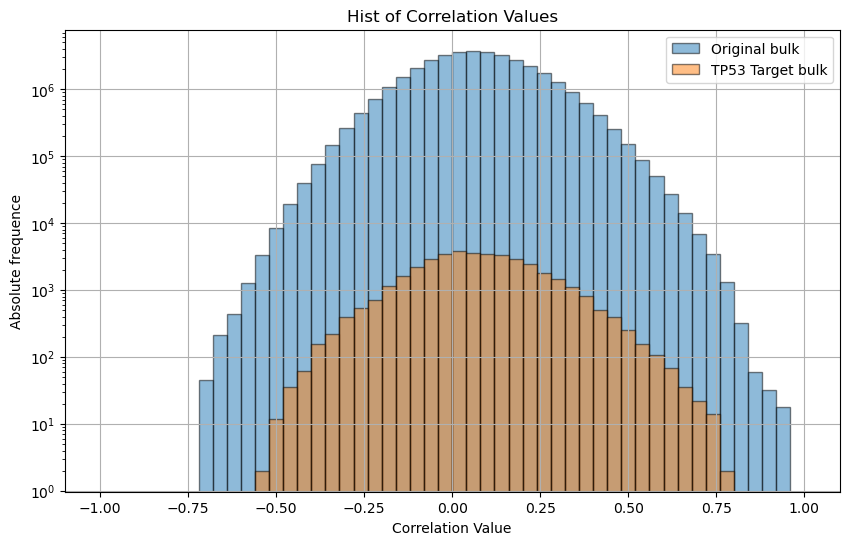

In [88]:
plot_frequency_of_correlation_values({"Original bulk":mat_original_bulk,"TP53 Target bulk":mat_tab1_bulk})

## scatter plot of bulk data

!!! Not sure how we can do a scatter plot if we don't have two continuous variable. You're missing something ASK AND CHECK !!!

## barplot divided by mut or wt

In [25]:
#crea df target bulk
df_tab1_bulk_with_mutstatus = df_bulk[df_bulk_tab1_gene_symbol + ["mutation_type"]].copy()
df_tab1_bulk_with_mutstatus.shape

NameError: name 'df_bulk_tab1_gene_symbol' is not defined

In [90]:
df_tab1_bulk_mut = df_tab1_bulk_with_mutstatus[ df_tab1_bulk_with_mutstatus["mutation_type"] == "mut" ].copy()
df_tab1_bulk_wt = df_tab1_bulk_with_mutstatus[ df_tab1_bulk_with_mutstatus["mutation_type"] == "wt" ].copy()
print(df_tab1_bulk_mut.shape)
print(df_tab1_bulk_wt.shape)
mat_target_bulk_mut = network_constructor.build_correlation_matrix(df_tab1_bulk_mut, corr_threshold=0, p_value_threshold= 1, p_val="no") #PER ORA NO THRESHOLD
mat_target_bulk_wt =  network_constructor.build_correlation_matrix(df_tab1_bulk_wt, corr_threshold=0, p_value_threshold= 1, p_val="no") #PER ORA NO THRESHOLD

(969, 201)
(524, 201)


/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


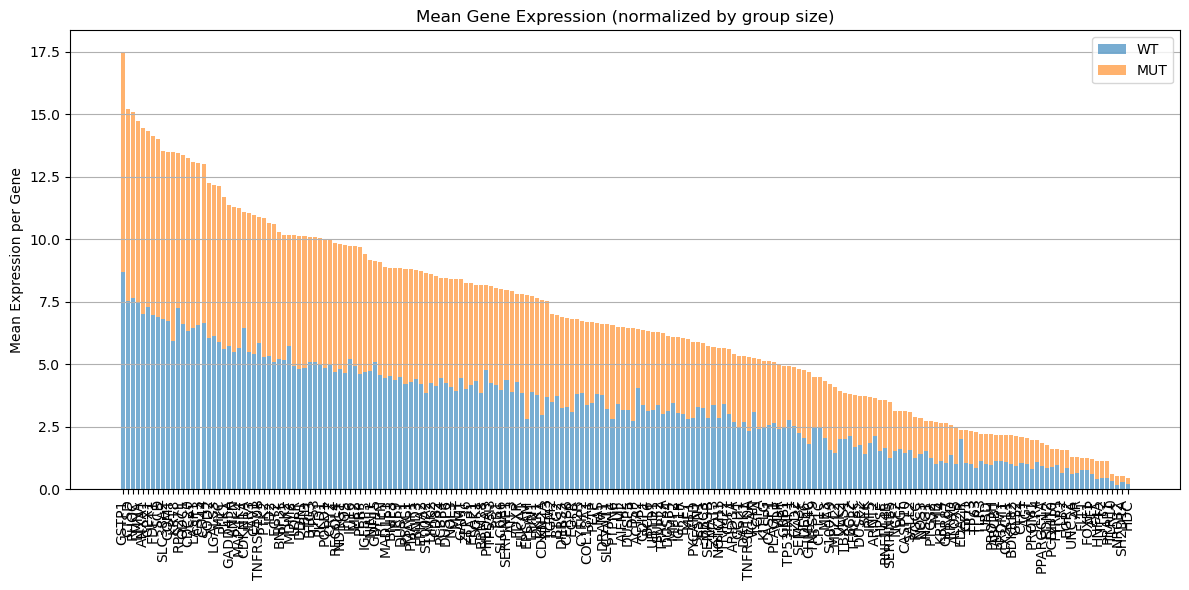

In [93]:
plot_mean_expression_by_gene(df_tab1_bulk_mut, df_tab1_bulk_wt)

This is just showing that the expression of the targets is higher in the mutated, but it is not saying that our target are better for class prediction than our HVG so it's not that significant

We also runned a model using only the target genes and we see that there is no improvement (still 100% both train and test)

# XGboost on bulk data

In [ ]:
df_bulk=pd.read_csv("../data/Target_genes/BulkCCLE_da_michele.csv")
df_bulk["mutation_type"]= np.where(df_bulk["mutation_type"]=="wt","wt","mut" )
df_bulk.columns=[col.split(" ")[0].strip() for col in df_bulk.columns]

mask = df_bulk["mutation_type"]=="wt"
print(f"n wt: {df_bulk[mask].shape[0]}")
print(f"n mut: {df_bulk[~mask].shape[0]}")
df_bulk['mutation_type'] = df_bulk['mutation_type'].map({'mut': 1, 'wt': 0})

n wt: 524
n mut: 969


In [74]:
import xgboost as xgb
X = df_bulk.drop(columns=['mutation_type',"Unnamed:"])
y = df_bulk['mutation_type']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))

/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [19:37:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.8494983277591973
Precision: 0.8465116279069768
Recall: 0.9381443298969072
F1 Score: 0.8899755501222494
AUC: 0.9001472754050074


# Get graph informations (debugging)

Number of nodes: 2449
Number of edges: 157154
NUmber of features per node: 1
Has isolated nodes: False
Has self-loops: False
Is undirected: True


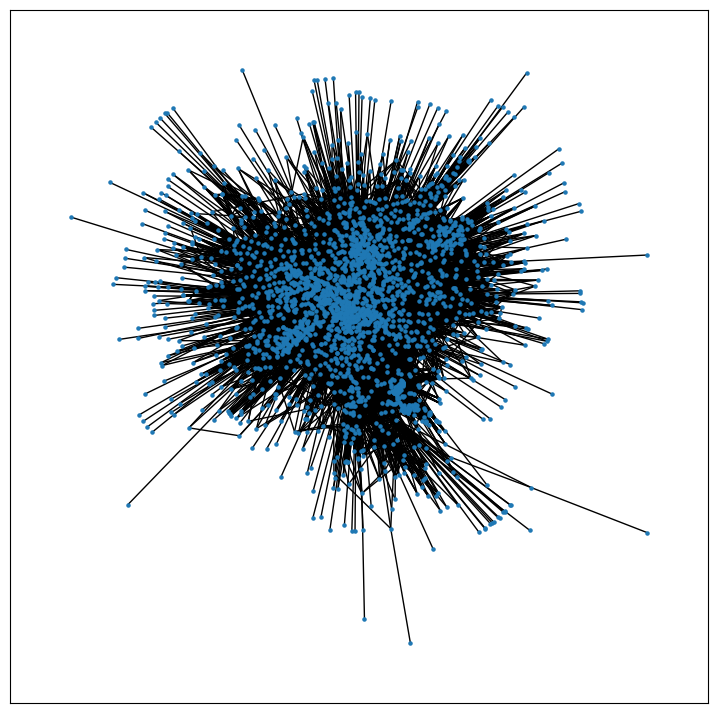

In [ ]:
prova_c02_p005_LCC= torch.load("../data/Vari_trial/graphs_02_treshold/batch_000.pt", weights_only=False)
'../data/Vari_trial /graphs_02_treshold'
network_constructor.get_info_and_plot_graph(prova_c02_p005_LCC)

Number of nodes: 3808
Number of edges: 157158
NUmber of features per node: 1
Has isolated nodes: True
Has self-loops: False
Is undirected: True


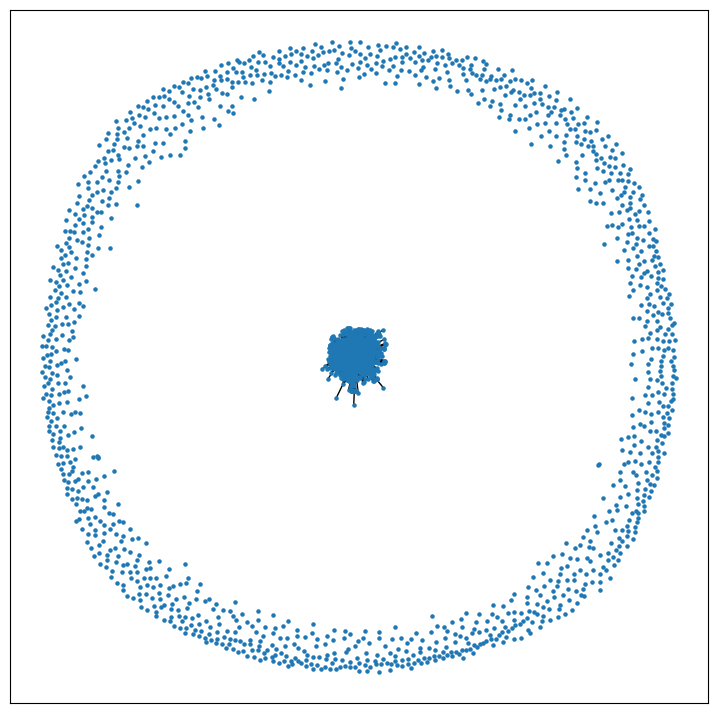

In [ ]:
prova_c02_p005_noLCC= torch.load("../data/graphs_c02_p005_noLCC/train/batch_000.pt", weights_only=False)
network_constructor.get_info_and_plot_graph(prova_c02_p005_noLCC)

In [ ]:
print(prova_c02_p005_noLCC[0].keys)

<bound method BaseData.keys of Data(x=[3808, 1], edge_index=[2, 157158], y=[1])>


In [ ]:
df = pd.read_csv("final_preprocessed_data.csv", index_col=0)
train_df, test_df =train_test_split(df, test_size=0.2, random_state=42)